In [1]:
# Launch 4 parallel processes and load module in all
addprocs(4)
import QuantumBayesian
@everywhere using QuantumBayesian

using PyPlot, HDF5, JLD

# Qubit Zeno Dragging Simulation

**Justin Dressel**, Jan 3, 2017 <br />
*Institute for Quantum Studies, Chapman University*

Simulate Zeno dragging for a single qubit (in its rotating frame), with realistic parameters used by the UC Berkeley team (courtesy of Shay Hacohen-Gourgy).

## Problem Parameters

Consider a qubit initially in its ground state that is being continuously measured along a slowly drifting axis.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = qubit()
@everywhere x(ρ) = real(expect(ρ, q("x")));
@everywhere z(ρ) = real(expect(ρ, q("z")));

In [3]:
Γ = 2π * 0.13;   # Total dephasing rate per measurement channel (MHz, 1.2μs decay time)
η1 = 0.49;       # Quantum efficiency of channel 1
η2 = 0.40;       # Quantum efficiency of channel 2
τ1 = 1/(2*Γ*η1); # Collapse timescale for channel 1
τ2 = 1/(2*Γ*η2); # Collapse timescale for channel 2
T = (0.0, 2.0);  # Time duration of simulation (in μs)
Δt = 0.001;      # Time discretization (1ns)

# Hamiltonian: no residual oscillations in x-z plane
H = (0.0).*q("y");

# Residual dephasing from rotating frame (at rate 0.0064 MHz, 25μs decay time)
@everywhere ΓR = 2π * 0.0064;
@everywhere DR = t -> sqrt(ΓR/2).*q("y");

# Initial ground state
ρ0 = ground(q);

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sols; plot_title="Zeno-dragged Trajectory", bloch=true, blochplane=true, readout=false, ch2=false, stds=[])
    # Plot Bloch components vs. time
    if bloch
        figure(1)
        ax = gca()
        ax[:set_ylim]([-1.1,1.1])
        hold(true)
        for sol in sols
            plot(sol[1].t, sol[1], label=L"$x$", color="r", alpha=0.8, antialiased=true)
            plot(sol[2].t, sol[2], label=L"$z$", color="g", alpha=0.8, antialiased=true)
            if length(stds) > 0
                fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
                fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
            end
        end
        xlabel(L"$t\,(\mu s)$")
        ylabel("Bloch coordinates")
        title(plot_title)
        legend()
        hold(false)
        show()
    end
    # Plot Bloch x-z plane
    if blochplane
        figure(2)
        hold(true)
        tt = linspace(0,2π,100)
        plot(cos(tt), sin(tt), color="k", linestyle="--")
        for sol in sols
            plot(sol[1], sol[2], alpha=0.8, antialiased=true)
        end
        ax = gca()
        ax[:set_ylim]([-1.1,1.1])
        ax[:set_xlim]([-1.1,1.1])
        ax[:set_aspect]("equal")
        grid(true)
        xlabel(L"$x$")
        ylabel(L"$z$")
        title(plot_title*" Bloch Plane")
        show()
    end
    # Plot Readouts
    if readout
        figure(3)
        hold(true)
        for sol in sols
            plot(sol[3].t, sol[3], label=L"$r_z$", color="r", alpha=0.8, antialiased=true)
            ch2 && plot(sol[4].t, sol[4], label=L"$r_\phi$", color="g", alpha=0.8, antialiased=true)
            if length(stds) > 0
                fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="r", alpha=0.2, antialiased=true)
                ch2 && fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="g", alpha=0.2, antialiased=true)
            end
        end
        xlabel(L"$t\,(\mu s)$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        hold(false)
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = \frac{\Gamma_R}{2}\left[\sigma_y\,\rho\,\sigma_y^\dagger - \frac{\{\sigma_y^\dagger\sigma_y,\, \rho\}}{2}\right] + \frac{\Gamma}{2}\left[\sigma_z(t)\,\rho\,\sigma_z(t)^\dagger - \frac{\{\sigma_z(t)^\dagger\sigma_z(t),\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_\phi(t)$ if the second measurement channel is operating. Here the dragged measurement operators have the form:
$$ \sigma_z(t) = \cos(\Omega t)\, \sigma_z - \sin(\Omega t)\, \sigma_x $$
$$ \sigma_\phi(t) = \cos(\Omega t + \phi)\, \sigma_z - \sin(\Omega t + \phi)\, \sigma_x $$
The residual dephasing is $\Gamma_R/2\pi = 0.04$MHz. The measurement dephasing per channel is $\Gamma/2\pi = 0.13$MHz.

In [5]:
# Dragging measurement channel 1 at frequency Ω
D1(Ω) = t -> sqrt(Γ/2).*( cos(Ω*t).*q("z") - sin(Ω*t).*q("x") )

# Dragging measurement channel 2 at frequency Ω, offset by angle ϕ
D2(ϕ, Ω) = t -> sqrt(Γ/2).*( cos(Ω*t + ϕ).*q("z") - sin(Ω*t + ϕ).*q("x") )

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(Ω=2π*0.01; T=T, ch2=false, ϕ=0.0, verbose=true)
    inc = lind(Δt, H, DR, D1(Ω))
    ch2 && (inc = lind(Δt, H, DR, D1(Ω), D2(ϕ,Ω)))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose)
end;

The plots below are for verification against existing Lindblad evolution code, to double-check that parameters are set correctly.

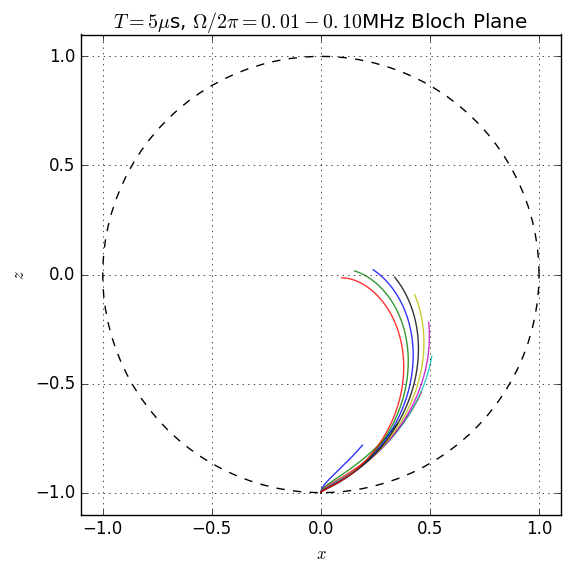

In [6]:
sols = [ensemble_average(2π*k, T=(0.0, 5.0), verbose=false) for k in 0.01:0.01:0.10]
plot_solution(sols, bloch=false, plot_title=L"$T=5\mu$s, $\Omega/2\pi=0.01-0.10$MHz")

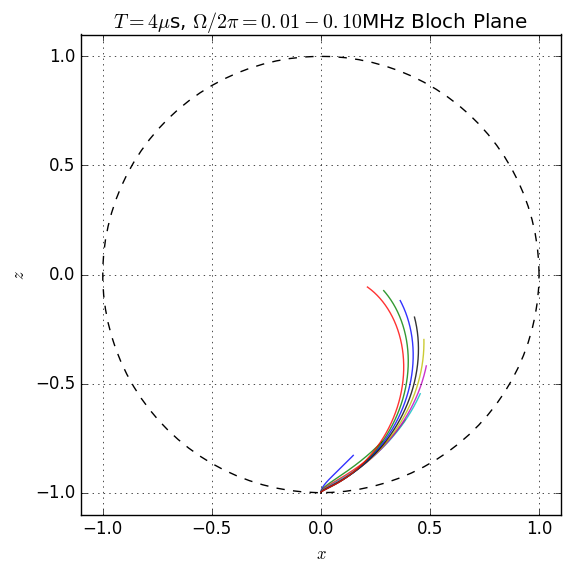

In [7]:
sols = [ensemble_average(2π*k, T=(0.0, 4.0), verbose=false) for k in 0.01:0.01:0.10]
plot_solution(sols, bloch=false, plot_title=L"$T=4\mu$s, $\Omega/2\pi=0.01-0.10$MHz")

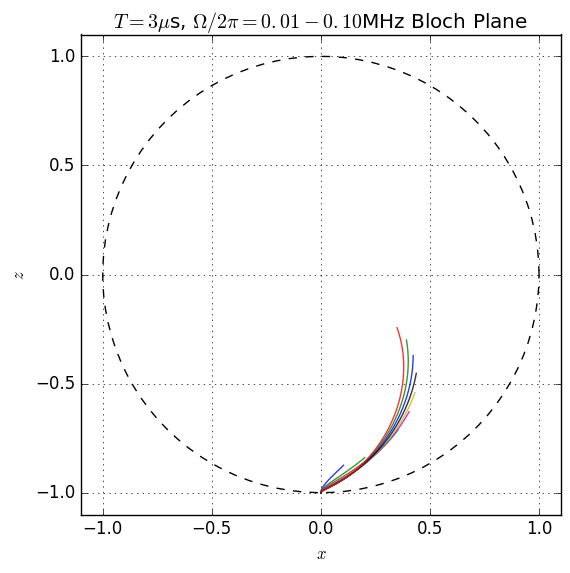

In [8]:
sols = [ensemble_average(2π*k, T=(0.0, 3.0), verbose=false) for k in 0.01:0.01:0.10]
plot_solution(sols, bloch=false, plot_title=L"$T=3\mu$s, $\Omega/2\pi=0.01-0.10$MHz")

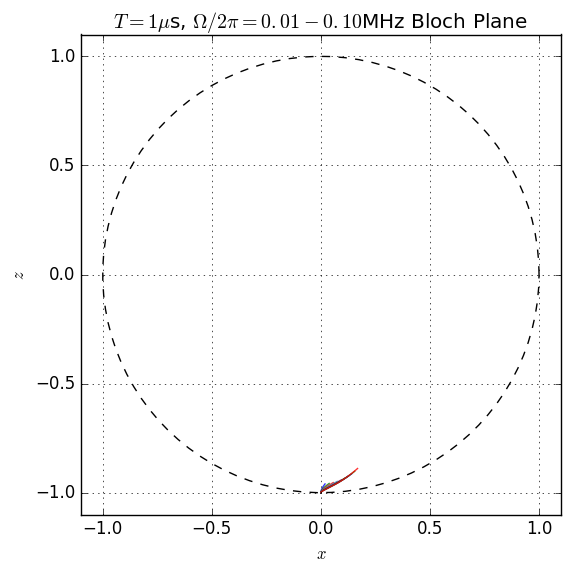

In [9]:
sols = [ensemble_average(2π*k, T=(0.0, 1.0), verbose=false) for k in 0.01:0.01:0.10]
plot_solution(sols, bloch=false, plot_title=L"$T=1\mu$s, $\Omega/2\pi=0.01-0.10$MHz")

## Stochastic Dynamics

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = \frac{\Gamma}{2}\left[\sigma_z(t)\,\rho\,\sigma_z(t)^\dagger - \frac{\{\sigma_z(t)^\dagger\sigma_z(t),\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{2}}\left[\sigma_z(t)\,\rho + \rho\,\sigma_z(t)^\dagger - \langle\sigma_z(t)+\sigma_z(t)^\dagger\rangle\,\rho\right]dW $$

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z(t) $$
corresponding to the measured observable. This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -\, \frac{dt\,(r-A)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the residual dephasing, yielding the completely positive map:
$$ \rho(t+dt) = \frac{\gamma\,dt}{2}\,A\,M_r\,\rho(t)\,M_r^\dagger\,A^\dagger + \sqrt{1 - \frac{\gamma\,dt}{2}A^\dagger A}\,M_r\,\rho(t)\,M_r^\dagger\,\sqrt{1 - \frac{\gamma\,dt}{2}A^\dagger A} $$

In [10]:
# Dragging measurement channel 1 at frequency Ω
A1(Ω) = t -> cos(Ω*t).*q("z") - sin(Ω*t).*q("x")

# Dragging measurement channel 2 at frequency Ω, offset by angle ϕ
A2(ϕ, Ω) = t -> cos(Ω*t + ϕ).*q("z") - sin(Ω*t + ϕ).*q("x")

function ensemble_realization(Ω=2π*0.01; n=1, ch2=false, ϕ=0.0, verbose=true, T=(0.0, 4.0))
    # Monitoring with tunable quantum efficiency
    inc = meas(Δt, H, [(A1(Ω), τ1, η1)], DR)
    ch2 && (inc = meas(Δt, H, [(A1(Ω), τ1, η1), (A2(ϕ, Ω), τ2, η2)], DR))
    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    end
end;

### Single Trajectory Examples

INFO: Trajectory: steps = 4999, points = 4999, values = 2
INFO: Readout: values = 1


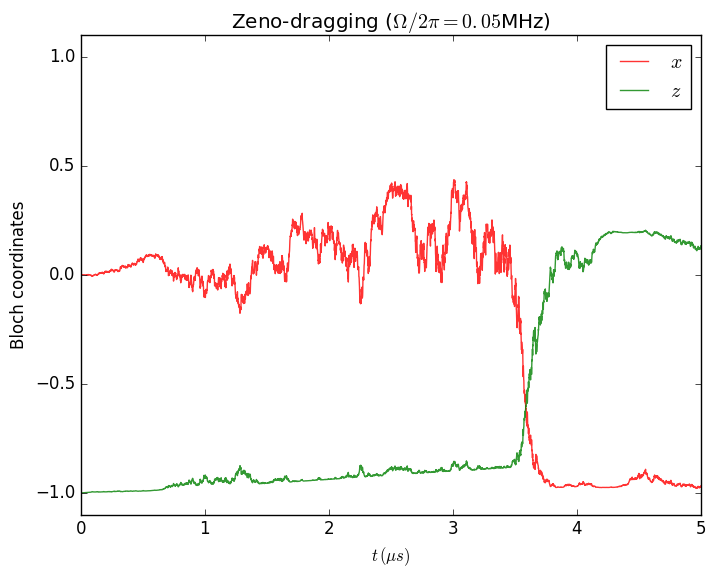

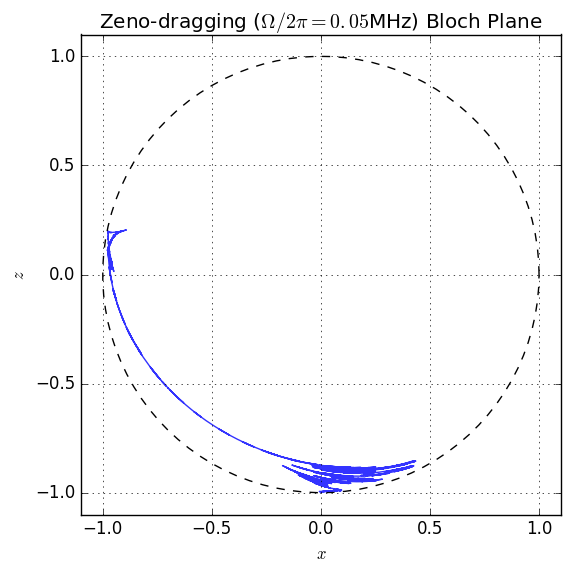

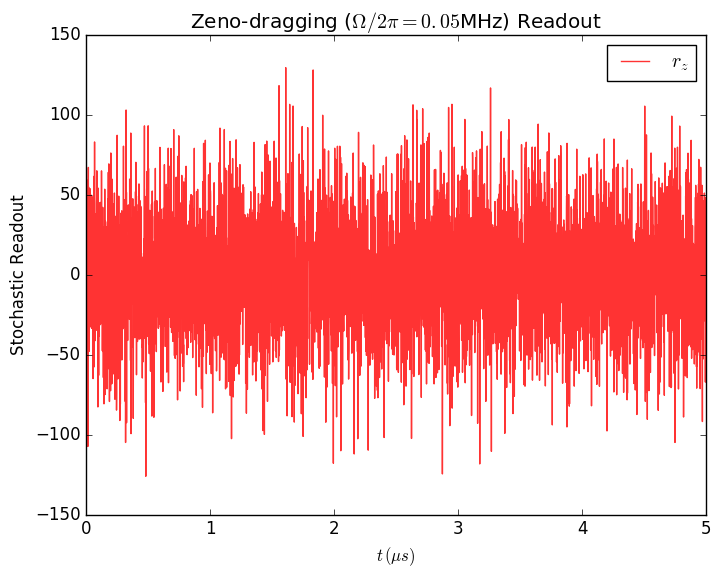

INFO: Time elapsed: 1.583435226 s, Steps per second: 3157.059990782345


In [11]:
sols = ensemble_realization(2π*0.05, n=1, T=(0.0, 5.0));
plot_solution([sols], readout=true, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz)")

In [12]:
sols = ensemble_realization(2π*0.05, n=5, T=(0.0, 5.0));

INFO: Trajectories: 5, steps each: 4999, points each: 4999, values each = 2
INFO: Readouts: values each = 1
INFO: Time elapsed: 12.906612138 s, Steps: 24995, Steps per second: 1936.6042562330542


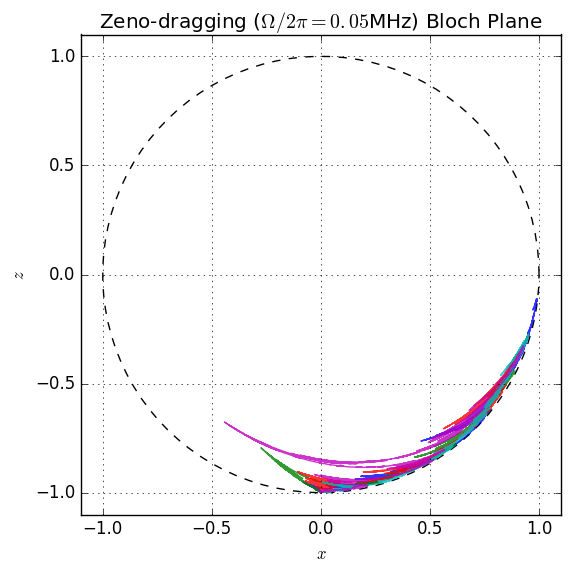

In [13]:
plot_solution([[sols[1](k), sols[2](k), sols[3](k)] for k in 1:sols[1].n], bloch=false, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz)")

### Ensembles of trajectories

First we plot the reference Lindblad solution that an ensemble should average to.

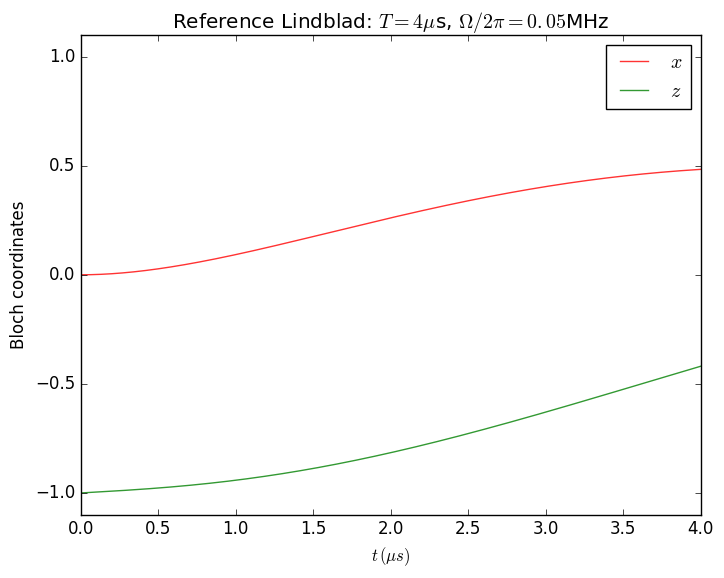

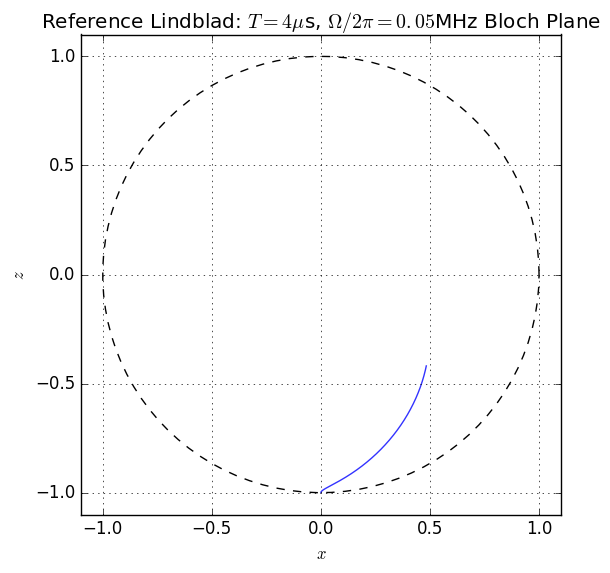

In [14]:
sols = ensemble_average(2π*0.05, T=(0.0, 4.0), verbose=false)
plot_solution([sols], bloch=true, plot_title=L"Reference Lindblad: $T=4\mu$s, $\Omega/2\pi=0.05$MHz")

Next we compute ensembles of different sizes and compare.

In [15]:
# Ensemble size, for easy tunability
ntraj = 5;

In [16]:
sols = ensemble_realization(2π*0.05, n=ntraj, T=(0.0, 4.0));

INFO: Trajectories: 5, steps each: 3999, points each: 3999, values each = 2
INFO: Readouts: values each = 1
INFO: Time elapsed: 3.350221792 s, Steps: 19995, Steps per second: 5968.261578306872


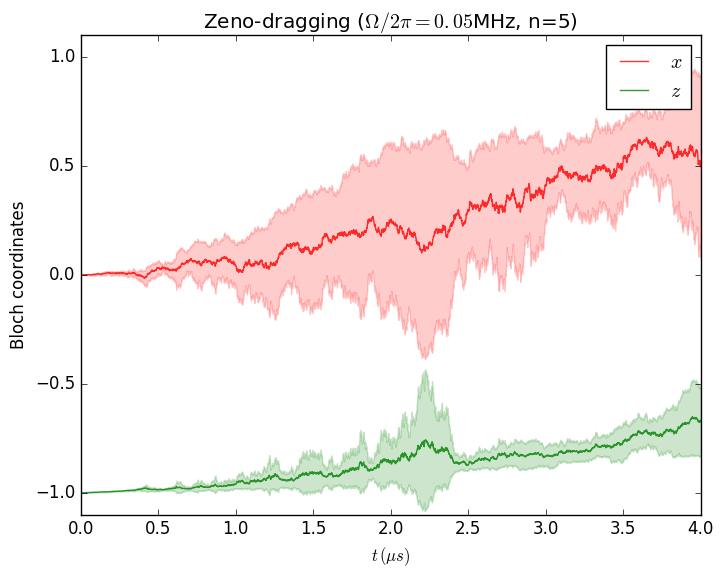

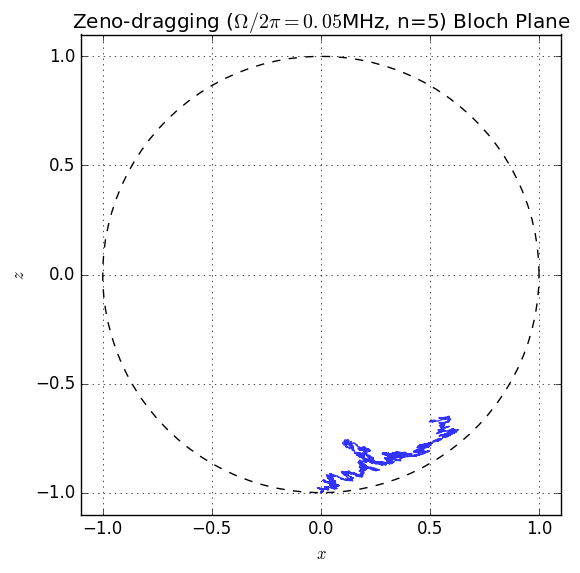

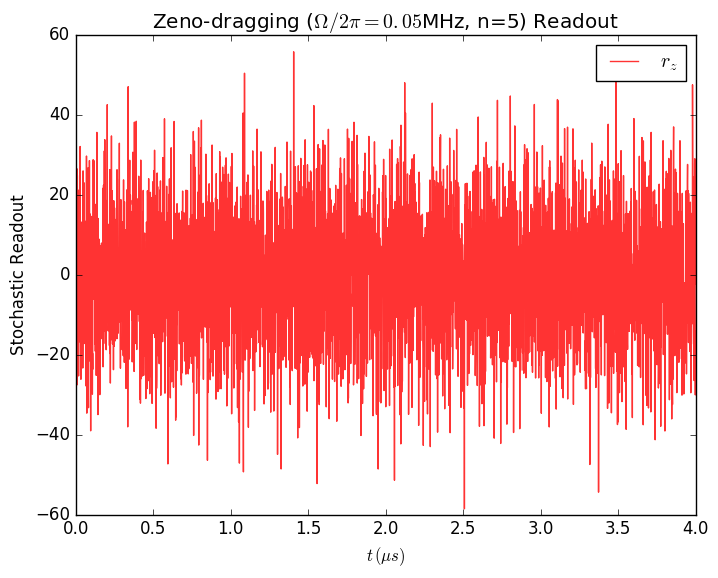

In [17]:
plot_solution([map(mean, sols)], stds=map(std, sols), plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))
plot_solution([map(mean, sols)], bloch=false, blochplane=false, readout=true, plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))

In [18]:
# Ensemble size, for easy tunability
ntraj = 100;

In [19]:
sols = ensemble_realization(2π*0.05, n=ntraj, T=(0.0, 4.0));

INFO: Trajectories: 100, steps each: 3999, points each: 3999, values each = 2
INFO: Readouts: values each = 1
INFO: Time elapsed: 55.393739826 s, Steps: 399900, Steps per second: 7219.227321645832


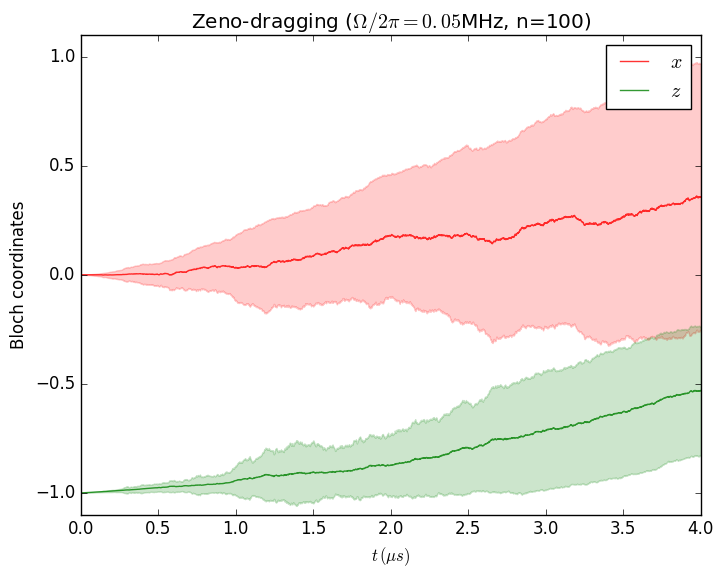

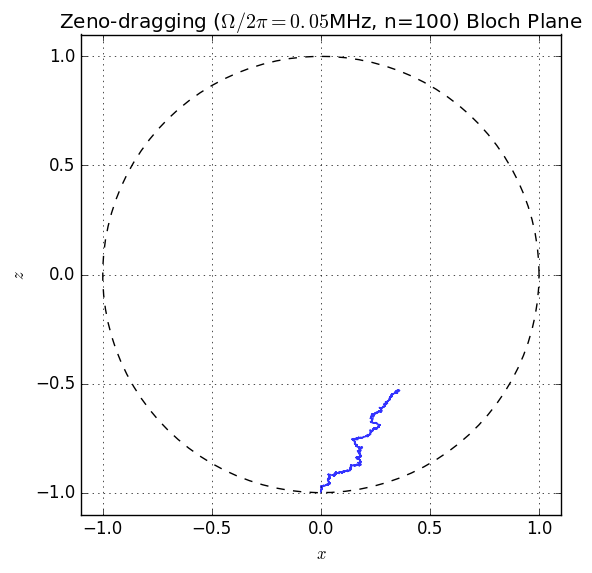

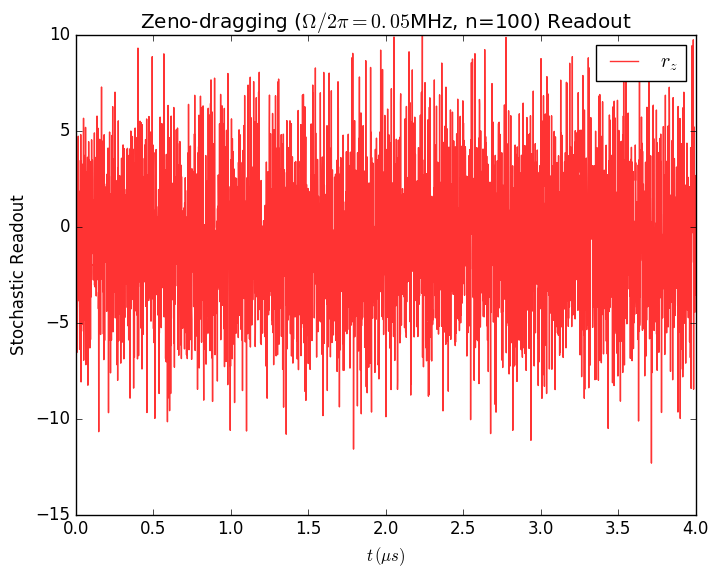

In [20]:
plot_solution([map(mean, sols)], stds=map(std, sols), plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))
plot_solution([map(mean, sols)], bloch=false, blochplane=false, readout=true, plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))

In [21]:
# Ensemble size, for easy tunability
ntraj = 30000;

In [22]:
sols = ensemble_realization(2π*0.05, n=ntraj, T=(0.0, 4.0));

INFO: Trajectories: 30000, steps each: 3999, points each: 3999, values each = 2
INFO: Readouts: values each = 1
INFO: Time elapsed: 14411.447478368 s, Steps: 119970000, Steps per second: 8324.632218941118


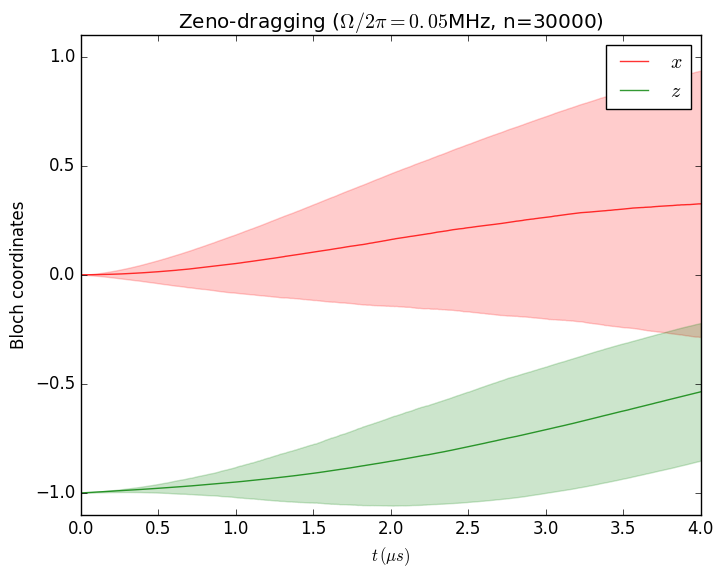

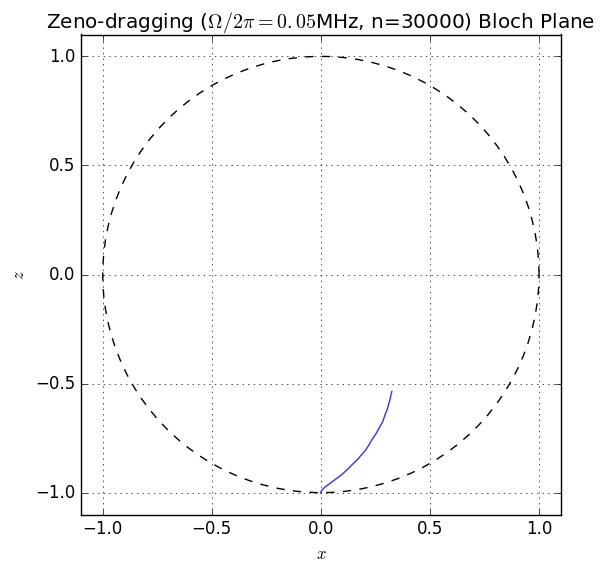

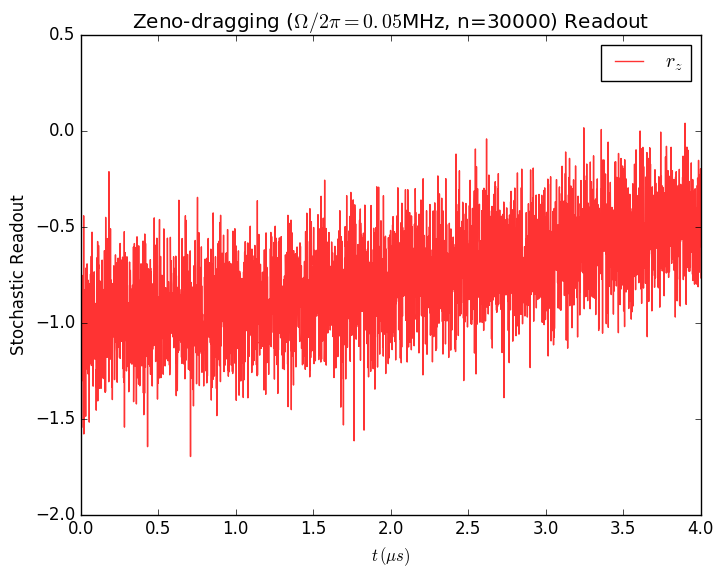

In [23]:
plot_solution([map(mean, sols)], stds=map(std, sols), plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))
plot_solution([map(mean, sols)], bloch=false, blochplane=false, readout=true, plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))

In [24]:
save("ensemble.jld", "x", sols[1], "z", sols[2], "r", sols[3])

## Version Information

In [25]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6560U CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


In [26]:
Pkg.installed("PyPlot")

v"2.2.4"

In [27]:
Pkg.installed("QuantumBayesian")

v"0.1.0+"

In [28]:
Pkg.installed("Interpolations")

v"0.3.6"